In [1]:
from dataloader import load_balanced_dataset
import backend.src.utils.utils as utils

In [2]:
data = load_balanced_dataset()
data = utils.clean_text(data, "text")

In [3]:
data

,sent_id,text,label
9909,400258-10-01,garrone laget vakker visuell lek farger flotte...,2
9551,400620-14-01,kanskje morsomste compton stjernelaget califor...,2
9376,601619-03-01,starter mørkt intenst gosh går videre dypeste ...,2
3827,500322-08-04,krigsfilm åpner syn selvstendig tenkning rundt...,2
3659,601343-06-02,smart grep forfatteren jo representerer fritta...,2
...,...,...,...
2449,304309-05-01,uskyldig,0
5554,602157-07-02,dessverre prater publikum høyt nyte lavestepar...,0
8394,103992-13-04,ta takke åpenbar umenneskelig behandling sitte...,0
3886,101857-06-01,kvinneavdelingen virker brutal,0


In [4]:
from collections import Counter
import math

num_words = Counter()
for review in data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 16000


<AxesSubplot:>

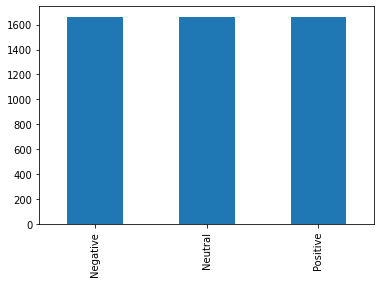

In [5]:
data["label"].replace({0: "Negative", 1: "Neutral", 2: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

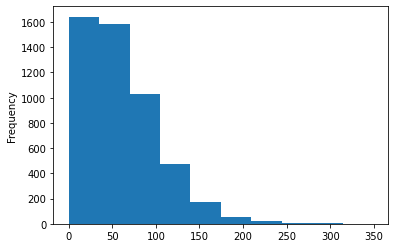

In [6]:
data["text"].str.len().plot.hist()

In [7]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(data["text"], data["label"], test_size=0.2, random_state=42,
                                                  shuffle=True)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [8]:
from collections import Counter

word_counter = Counter()
for review in X_train:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [9]:
word_counter.most_common(10)

[('litt', 149),
 ('får', 113),
 ('gjør', 113),
 ('the', 105),
 ('to', 102),
 ('filmen', 101),
 ('–', 101),
 ('helt', 94),
 ('første', 93),
 ('år', 90)]

In [10]:
y_train = np.array(y_train)
y_val = np.array(y_val)

maxlen = 150
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (3991, 150)
X_val shape: (998, 150)
y_train shape: (3991, 3)
y_val shape: (998, 3)


In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128))
model.add(LSTM(units=128, dropout=0.5))
model.add(Dense(3, activation='softmax'))

In [12]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2048000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 2,179,971
Trainable params: 2,179,971
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
250/250 [==============================] - 57s 216ms/step - loss: 1.0686 - accuracy: 0.4157 - val_loss: 1.0459 - val_accuracy: 0.4669
Epoch 2/20
250/250 [==============================] - 52s 208ms/step - loss: 0.7549 - accuracy: 0.7021 - val_loss: 1.0718 - val_accuracy: 0.5180
Epoch 3/20
250/250 [==============================] - 53s 212ms/step - loss: 0.2794 - accuracy: 0.8980 - val_loss: 1.3104 - val_accuracy: 0.5200
Epoch 4/20
250/250 [==============================] - 42s 168ms/step - loss: 0.1121 - accuracy: 0.9614 - val_loss: 1.7212 - val_accuracy: 0.5160
Epoch 5/20
250/250 [==============================] - 36s 146ms/step - loss: 0.0630 - accuracy: 0.9800 - val_loss: 1.8118 - val_accuracy: 0.5120
Epoch 6/20
250/250 [==============================] - 39s 156ms/step - loss: 0.0343 - accuracy: 0.9907 - val_loss: 2.1706 - val_accuracy: 0.5110


In [14]:
from datetime import datetime

model.save(f"models/SA-LSTM-MULTICLASS-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

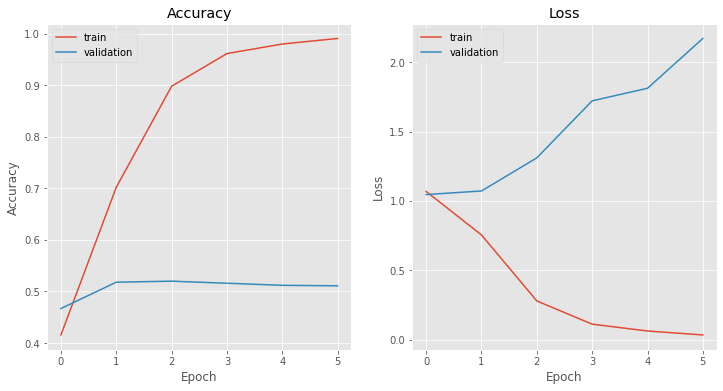

In [15]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [16]:
# Evaluation
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

32/32 [==============================] - 2s 53ms/step - loss: 2.1706 - accuracy: 0.5110
Validation loss: 2.170604944229126
Validation accuracy: 0.5110220313072205
